In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import jax
from scipy.stats import beta
from jax.scipy.special import betaln
from jax.scipy.special import gammaln
from jax.scipy.special import digamma
from numpy.random import multivariate_normal as mvn
from numpy.random import gamma
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_normal
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
!pip install mycolorpy
from mycolorpy import colorlist as mcp
from scipy.stats import bernoulli

  Preparing metadata (setup.py) ... done
  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3851 sha256=9a06ebbb73cab853bbdaf276990b2678cd2176ed5a886ded5894fe73e6aa4642
  Stored in directory: /root/.cache/pip/wheels/d6/1d/04/f8bfb8b04e3daba330b3f377c041b89304271ff98fb6704946
Successfully built mycolorpy


In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [3]:
seed = 2022
key = random.PRNGKey(seed)

n = 1000
d = 2

In [4]:
# n of cluster and pi generation
K = 50

alpha = 5.0 #bigger alpha, more clusters
vi = beta.rvs(alpha, 1, size = K)

pi = np.cumprod(vi)

In [5]:
# Z generation

Z = np.zeros((n,K))

for i in range(0, n):
  for j in range(0, K):
    Z[i,j] = bernoulli.rvs(pi[j])

In [6]:
# A generation

A = np.zeros((K,d))
sigma2a = 5.0
Id = np.eye(d)
mu0 = np.zeros(d)

for i in range(0, K):
  A[i] = mvn(mu0, sigma2a*Id)

In [9]:
# Finally X
X=np.zeros((n,d))
sigma2x=1.0
for i in range(n):
  X[i,:] = mvn(jnp.matmul(Z[i,:],A),sigma2x*Id)

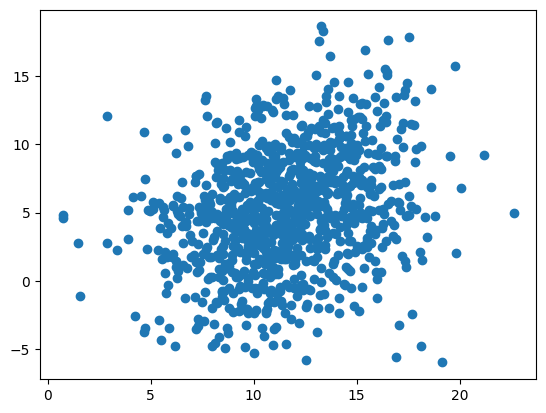

In [10]:
x = X[:,0]
y = X[:,1]

plt.scatter(x, y)
plt.show()

In [24]:
def update_tau(nu,alpha,multinomial_q):
  K=nu.shape[1]
  N=nu.shape[0]
  updated_tau=jnp.zeros((K,2),dtype=jnp.float64)
  nu_sum=jnp.sum(nu,axis=0)
  nu_sum_inv=nu_sum[::-1]
  nu_cumsum_inv=jnp.cumsum(nu_sum_inv)
  nu_cumsum=nu_cumsum_inv[::-1]
  nu_sum_cumsum=jnp.cumsum(nu_sum)
  q_cumsum=jnp.cumsum(multinomial_q,axis=1)
  updated_tau=updated_tau.at[:,0].set(alpha+nu_cumsum + (N-nu_sum) @ (1-q_cumsum))
  #updated_tau=updated_tau.at[:-1,0].add((K-jnp.arange(1,K))*N - nu_sum_cumsum[:-1])
  #updated_tau=updated_tau.at[1:,0].add(jnp.arange(K-1)*N - jnp.cumsum(nu_sum)[:-1])
  updated_tau=updated_tau.at[:,1].set(1+ (N-jnp.sum(nu,axis=0)) @ multinomial_q)

  return updated_tau

update_tau_jit=jit(update_tau)

def update_nu(data,tau,phi_means,phi_variances,nu,sigma2x,alpha,multinomial_q):
  N=data.shape[0]
  K=phi_means.shape[0]
  d=data.shape[1]
  log_likelihood=jnp.zeros((N,K),dtype=jnp.float64)
  updated_nu=jnp.zeros((N,K),dtype=jnp.float64)
  digamma_cumsum=jnp.cumsum(digamma(tau[:,0]-digamma(tau[:,0]+tau[:,1])))
  q_mat_cumsum=jnp.cumsum(multinomial_q,axis=1)
  q_mat_cumsum_tril=jnp.tril(q_mat_cumsum,k=-1)
  log_likelihood=1/sigma2x*(data @ phi_means.T - ((nu @ phi_means) @ phi_means.T - nu*jnp.resize(jnp.diag(phi_means @ phi_means.T),(K))))
  log_likelihood=log_likelihood.at[:,:].add(-0.5/sigma2x*jnp.resize(d*phi_variances,(K,)))
  log_likelihood=log_likelihood.at[:,:].add(-0.5/sigma2x*jnp.resize(jnp.diag(phi_means @ phi_means.T),(K,)))
  log_likelihood=log_likelihood.at[:,:].add(digamma_cumsum + jnp.sum(multinomial_q*jnp.log(multinomial_q),axis=1))
  log_likelihood=log_likelihood.at[:,:].add(-(multinomial_q @ digamma(tau[:,1])) - jnp.cumsum(digamma(tau[:,0]+tau[:,1])))
  log_likelihood=log_likelihood.at[:,1:].add(+ (jnp.cumsum(digamma(tau[:-1,0]))) + q_mat_cumsum_tril[1:,:-1] @ digamma(tau[:-1,0]) - ( q_mat_cumsum_tril[1:,:-1] @ digamma(tau[1:,0]+tau[1:,1])))
  updated_nu=1/(1-jnp.exp(log_likelihood))
  updated_nu=updated_nu.at[:,:].max(10**(-307))
  updated_nu=updated_nu.at[:,:].min(1-10**(-5))
  return updated_nu

update_nu_jit=jit(update_nu)

def update_phi(data,nu,sigma2a,sigma2x,phi_means):
  N=data.shape[0]
  d=data.shape[1]
  K=nu.shape[1]
  updated_phi_means=jnp.zeros((K,d),dtype=jnp.float64)
  updated_phi_variances=jnp.zeros((K,),dtype=jnp.float64)
  updated_phi_variances=1/(jnp.sum(nu,axis=0)/sigma2x+1/sigma2a)
  updated_phi_means= (nu.T @ data-(nu.T @ (nu @ phi_means))+jnp.sum(nu**2,axis=0)[:,None]*phi_means)/sigma2x*updated_phi_variances[:,None]
  return updated_phi_means,updated_phi_variances

update_phi_jit=jit(update_phi)

def update_q(tau):
  K=tau.shape[0]
  updated_multi_q=jnp.zeros((K,),dtype=jnp.float64)
  digamma_cumsum=jnp.cumsum(digamma(tau[:,0]-digamma(tau[:,0]+tau[:,1])))
  updated_multi_q=jnp.exp(digamma(tau[:,1])-digamma(tau[:,0])+digamma_cumsum)
  updated_multi_q=jnp.nan_to_num(updated_multi_q, nan=10**-10, posinf=jnp.float64(10**308/K))
  # updated_multi_q=updated_multi_q.at[:,:].min(1-10**(-5)/K) abbiamo solo log diq non anche di 1-q, per ora non serve questo
  updated_multi_q_matrix=jnp.tile(updated_multi_q,(K,1))
  updated_multi_q_matrix=jnp.tril(updated_multi_q_matrix)
  updated_multi_q_matrix/=jnp.sum(updated_multi_q_matrix,axis=1,keepdims=True)
  updated_multi_q_matrix=updated_multi_q_matrix.at[:,:].max(10**-307)

  return updated_multi_q_matrix

update_q_jit=jit(update_q)

In [25]:
def compute_ELBO(data,phi_means,phi_variances,tau,nu,sigma2a,sigma2x,alpha,multinomial_q):
  K=phi_means.shape[0]
  d=data.shape[1]
  N=data.shape[0]
  T1=jnp.sum(betaln(tau[:,0],tau[:,1]))+jnp.sum(-(tau[:,0]-1)*digamma(tau[:,0])-(tau[:,1]-1)*digamma(tau[:,1])+(tau[:,0]+tau[:,1]-2)*digamma(tau[:,0]+tau[:,1]))
  T1+= d/2*jnp.sum(jnp.log(phi_variances))
  T1+= jnp.sum(-nu*jnp.log2(nu)-(1-nu)*jnp.log2(1-nu))

  T2=(alpha-1)*jnp.sum(digamma(tau[:,0])-digamma(tau[:,0]+tau[:,1]))

  T3 = -0.5/sigma2a*((jnp.sum(d*phi_variances)) + jnp.sum(jnp.diag(phi_means @ phi_means.T)))

  digamma_cumsum=jnp.cumsum(digamma(tau[:,0]-digamma(tau[:,0]+tau[:,1])))
  T4 = jnp.sum(nu @ digamma_cumsum) - jnp.sum( (1-nu) @ jnp.sum(multinomial_q*jnp.log(multinomial_q),axis=1))

  q_mat_cumsum=jnp.cumsum(multinomial_q,axis=1)
  q_mat_cumsum_tril=jnp.tril(q_mat_cumsum,k=-1)
  T4 += (1-jnp.sum(nu,axis=0)) @ (multinomial_q @ digamma(tau[:,1])) + (1-jnp.sum(nu[:,1:],axis=0)) @ (jnp.cumsum(digamma(tau[:-1,0])) - q_mat_cumsum_tril[1:,:-1] @ digamma(tau[:-1,0]))
  T4 += -(1-jnp.sum(nu,axis=0)) @ jnp.cumsum(digamma(tau[:,0]+tau[:,1])) + (1-jnp.sum(nu[:,1:],axis=0)) @ ( q_mat_cumsum_tril[1:,:-1] @ digamma(tau[1:,0]+tau[1:,1]))

  T5 = -0.5/sigma2x*(-2*jnp.sum(jnp.diag((nu @ phi_means) @ data.T))+ jnp.sum(nu @ (d*phi_variances + jnp.diag(phi_means @ phi_means.T))))

  return T1+T2+T3+T4+T5

compute_ELBO_jit=jit(compute_ELBO)

In [26]:
def single_iteration_VI(data,K,i,nMax,tol,sigma2a,sigma2x,alpha):

  # initialize the parameters
  N=data.shape[0]
  d=data.shape[1]
  key = random.PRNGKey(i*seed)
  # random initialization of the variational parameters
  phi_means=random.normal(key,shape=(K,d))*jnp.sqrt(sigma2a)
  phi_variances= random.gamma(key,a=2.0,shape=(K,),dtype=jnp.float64)
  tau=jnp.array(random.geometric(key,0.25,(K,2)),dtype=jnp.float64)
  nu=random.uniform(key,shape=(N,K),dtype=jnp.float64)
  multinomial_q=random.uniform(key,shape=(K,K),dtype=jnp.float64)
  multinomial_q=jnp.tril(multinomial_q)
  multinomial_q/=jnp.sum(multinomial_q,axis=1,keepdims=True)
  multinomial_q=multinomial_q.at[:,:].max(10**-307)
  improvement=1
  ELBO_new= compute_ELBO_jit(data,phi_means,phi_variances,tau,nu,sigma2a,sigma2x,alpha,multinomial_q)
  ELBO_old=ELBO_new-1
  nit=0

  # codition funztion for the while loop
  def cond(state):
    _,_,_,_,_,_,_,_,nit,_,improvement,tol,nMax,_=state
    return (((improvement>tol) & (nit<nMax)))

  # body function for the while loop
  def iteration_while(state):
    data,tau,nu,phi_variances,phi_means,sigma2a,sigma2x,alpha,nit,ELBO_new,improvement,tol,nMax,multinomial_q=state
    # update of variational parameters
    phi_means,phi_variances=update_phi_jit(data,nu,sigma2a,sigma2x,phi_means)
    tau=update_tau_jit(nu,alpha,multinomial_q)
    nu=update_nu_jit(data,tau,phi_means,phi_variances,nu,sigma2x,alpha,multinomial_q)
    multinomial_q=update_q_jit(tau)
    # we resize tau2 this way for matrix multiplications
    ELBO_old=ELBO_new
    # computation of ELBO and imporvement
    ELBO_new=compute_ELBO_jit(data,phi_means,phi_variances,tau,nu,sigma2a,sigma2x,alpha,multinomial_q)
    improvement=ELBO_new-ELBO_old
    nit+=1
    return (data,tau,nu,phi_variances,phi_means,sigma2a,sigma2x,alpha,nit,ELBO_new,improvement,tol,nMax,multinomial_q)

  state=(data,tau,nu,phi_variances,phi_means,sigma2a,sigma2x,alpha,nit,ELBO_new,improvement,tol,nMax,multinomial_q)
  _,tau,nu,phi_variances,phi_means,_,_,_,nit,ELBO_new,_,_,_,multinomial_q=jax.lax.while_loop(cond_fun=cond,body_fun=iteration_while,init_val=state)

  return  tau,phi_means,phi_variances,nu,ELBO_new,nit,multinomial_q

single_iteration_VI_jit=jit(single_iteration_VI,static_argnames=['K'])

In [27]:
def VI(data,K,nMax,n_iniz,tol,sigma2a,sigma2x,alpha):
  ELBO_max=0
  for i in range(n_iniz):
    # every iteration we call the algorithm function, then if the ELBO is better than the one before we save it, otherwise we simply go on
    tau,phi_means,phi_variances,nu,ELBO_new,nit,multinomial_q=single_iteration_VI_jit(data,K,i,nMax,tol,sigma2a,sigma2x,alpha)
    if i==0:
      ELBO_max=ELBO_new
      phi_means_max=phi_means
      phi_variances_max=phi_variances
      tau_max=tau
      nu_max=nu
      multi_q_max=multinomial_q
      n_max=0
    print('Initialization number: ',i+1,'\t ELBO: ',ELBO_new,'\t N_iterations: ',nit)
    print('=================================================\n')
    if ELBO_new>ELBO_max:
      ELBO_max=ELBO_new
      phi_means_max=phi_means
      phi_variances_max=phi_variances
      tau_max=tau
      nu_max=nu
      multi_q_max=multinomial_q
      n_max=i
  print('Best initialization at ',n_max+1,' \t ELBO: ',ELBO_max,'\n\n')
  return tau,phi_means,phi_variances,nu,multi_q_max


In [28]:
nMax=1000
n_iniz=100
tol=10**-6
tau,means,variances,nu,multi_q=VI(X,K,nMax,n_iniz,tol,sigma2a,sigma2x,alpha)

Initialization number:  1 	 ELBO:  -39625490977.32302 	 N_iterations:  2

Initialization number:  2 	 ELBO:  -36444224027.483696 	 N_iterations:  2

Initialization number:  3 	 ELBO:  -12984481319.82545 	 N_iterations:  2

Initialization number:  4 	 ELBO:  -7012814073.616904 	 N_iterations:  2

Initialization number:  5 	 ELBO:  -15173588699.661402 	 N_iterations:  2

Initialization number:  6 	 ELBO:  -57585806426.784065 	 N_iterations:  2

Initialization number:  7 	 ELBO:  -4362279495.315421 	 N_iterations:  2

Initialization number:  8 	 ELBO:  -8705414475.128712 	 N_iterations:  2

Initialization number:  9 	 ELBO:  -2695610129.2970033 	 N_iterations:  2

Initialization number:  10 	 ELBO:  -38871436403.828705 	 N_iterations:  2

Initialization number:  11 	 ELBO:  -18450593275.870686 	 N_iterations:  2

Initialization number:  12 	 ELBO:  -1801904699.5165973 	 N_iterations:  2

Initialization number:  13 	 ELBO:  -2883936348.0423117 	 N_iterations:  2

Initialization number:  14